In [15]:
import openeo
import openeo.processes 

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [16]:
# defining area of interest
spatial_extent = {"west": 80.499, "south": 16.474, "east": 80.670, "north": 16.598}

In [17]:
#Reference Cube
s1_ref = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=["2017-02-02","2020-02-02"],
    spatial_extent=spatial_extent,
    bands=["VV"],
)
s1_ref = s1_ref.sar_backscatter(coefficient="sigma0-ellipsoid")

In [18]:
#Current DateCube
s1_cur = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=["2020-02-02", "2020-02-28"],
    spatial_extent=spatial_extent,
    bands=["VV"],
)
s1_cur = s1_cur.sar_backscatter(coefficient="sigma0-ellipsoid")

In [19]:
s1_cur = s1_cur.reduce_dimension(dimension='t',reducer='last')
dry_ref = s1_ref.reduce_dimension(dimension='t',reducer='min')
wet_ref = s1_ref.reduce_dimension(dimension='t',reducer='max')

In [20]:
#calculate Surface Soil Moisture
SSM = (s1_cur-dry_ref)/(wet_ref-dry_ref)

In [21]:
average_ref = s1_ref.reduce_dimension(dimension='t',reducer='mean')
average_ref = average_ref.apply(process=lambda data: 10 * openeo.processes.log(data, base=10))

In [22]:
VV = average_ref.band("VV")
mask = ((VV > -6) | (VV < -17))

#now let us apply the mask
SSM = SSM.mask(mask)

In [24]:
# Let's download the data
SSM.execute_batch(title="Surface Soil Moisture AMARAVATI", outputfile="SoilMoisture.nc")

0:00:00 Job 'j-25032917071241ba9d713ebbac6045ce': send 'start'
0:00:13 Job 'j-25032917071241ba9d713ebbac6045ce': created (progress 0%)
0:00:18 Job 'j-25032917071241ba9d713ebbac6045ce': created (progress 0%)
0:00:25 Job 'j-25032917071241ba9d713ebbac6045ce': created (progress 0%)
0:00:33 Job 'j-25032917071241ba9d713ebbac6045ce': created (progress 0%)
0:00:43 Job 'j-25032917071241ba9d713ebbac6045ce': created (progress 0%)
0:00:56 Job 'j-25032917071241ba9d713ebbac6045ce': created (progress 0%)
0:01:12 Job 'j-25032917071241ba9d713ebbac6045ce': created (progress 0%)
0:01:31 Job 'j-25032917071241ba9d713ebbac6045ce': queued (progress 0%)
0:01:55 Job 'j-25032917071241ba9d713ebbac6045ce': queued (progress 0%)
0:02:26 Job 'j-25032917071241ba9d713ebbac6045ce': queued (progress 0%)
0:03:03 Job 'j-25032917071241ba9d713ebbac6045ce': queued (progress 0%)
0:03:50 Job 'j-25032917071241ba9d713ebbac6045ce': queued (progress 0%)
0:04:49 Job 'j-25032917071241ba9d713ebbac6045ce': queued (progress 0%)
0:10:27

<BatchJob job_id='j-25032917071241ba9d713ebbac6045ce'>

In [25]:
import matplotlib.pyplot as plt
import xarray as xr

In [26]:
ds = xr.load_dataset("SoilMoisture.nc")

In [27]:
data = ds[["VV"]].to_array(dim="bands")

Text(0.5, 1.0, 'Surface Soil Moisture')

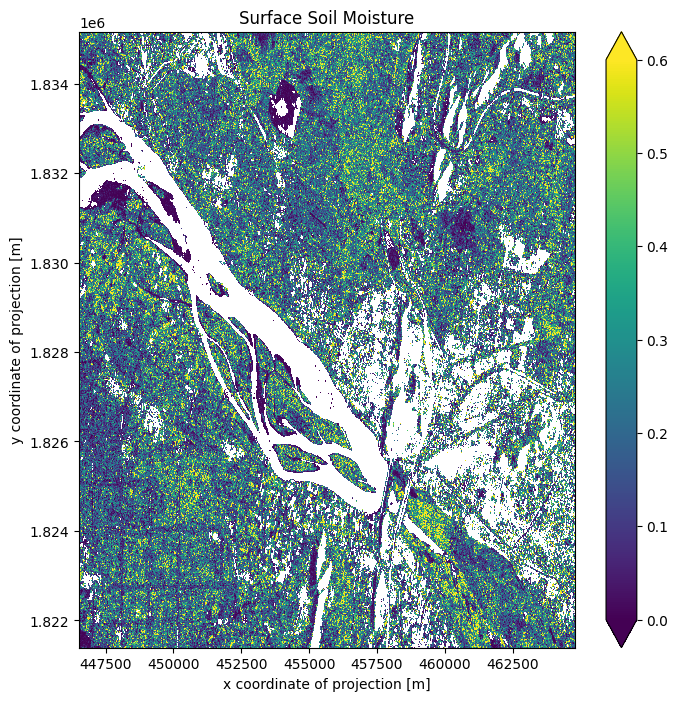

In [28]:
fig, axes = plt.subplots(ncols=1, figsize=(8, 8), dpi=100, sharey=True)
data[0].plot.imshow(ax=axes, vmax=0.6, vmin=0)
axes.set_title("Surface Soil Moisture")